<h2>Marketing Data Streamlit App Functions

<h3>Data 'Organisation' and Metric Calculation Functions

Functions are designed to be as arbritrary as possible so that the same function can be used for any of the category types for the EMIB analysis (Education Level, Marital Status, Income Bracket, and Birthyear).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform

In [2]:
def get_data(path:str)->pd.DataFrame:
    """
    Generates a dataframe from the 'superstore_data.csv' file located at the given path.
    """
    data = pd.read_csv(path)

    return data

In [3]:
data = get_data('superstore_data.csv')
data.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/05/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,08/04/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


In [4]:
def include_ts_bs(data: pd.DataFrame) -> pd.DataFrame:
    """
    Adds total monetary spent and total number of purchases columns to the dataframe (ts).

    Also adds the brackets/bins columns (bs) for the income and birthyear columns.

    Birthyear bins are as follows: '1940-1949', '1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999'

    Income bins are as follows: '0-9999', '10000-19999', '20000-29999', '30000-39999', '40000-49999', '50000-59999', '60000-69999', '70000-79999', '80000-89999', '90000-99999', '100000+'

    Parameters:
    data (pd.DataFrame): The input dataframe containing columns for individual monetary spends and purchases.

    Returns:
    pd.DataFrame: The dataframe with additional columns: 'TotalMntSpent', 'TotalNumPurchases', 'Birthyear_Bin', and 'Income_Bin'.
    """

    #Totals columns:
    data['TotalMntSpent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
    data['TotalNumPurchases'] = data['NumDealsPurchases'] + data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']  

    #Bin columns:
    income_bins = [0, 9999, 19999, 29999, 39999, 49999, 59999, 69999, 79999, 89999, 99999, np.inf]
    income_labels = ['0-9999', '10000-19999', '20000-29999', '30000-39999', '40000-49999', '50000-59999', '60000-69999', '70000-79999', '80000-89999', '90000-99999', '100000+']
    data['Income_Bin'] = pd.cut(data['Income'], bins=income_bins, labels=income_labels, right=False)

    birthyear_bins = [1940, 1950, 1960, 1970, 1980, 1990, 2000]
    birthyear_labels = ['1940-1949', '1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999']
    data['Birthyear_Bin'] = pd.cut(data['Year_Birth'], bins=birthyear_bins, labels=birthyear_labels, right=False)

    return data

In [5]:
data = include_ts_bs(data)
data.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,TotalMntSpent,TotalNumPurchases,Income_Bin,Birthyear_Bin
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,4,4,6,1,1,0,1190,15,80000-89999,1970-1979
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,3,7,5,1,0,577,18,50000-59999,1960-1969
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,3,2,5,2,0,0,251,11,60000-69999,1950-1959
3,1386,1967,Graduation,Together,32474.0,1,1,11/05/2014,0,10,...,1,0,2,7,0,0,11,4,30000-39999,1960-1969
4,5371,1989,Graduation,Single,21474.0,1,0,08/04/2014,0,6,...,3,1,2,7,1,0,91,8,20000-29999,1980-1989


In [6]:
def filter_level(data:pd.DataFrame,metric:str)->dict:
    """
    Filters the dataframe based on the unique level and returns a dictionary with dataframes for each unique level in a set of levels of a given metric e.g different education levels.

    Parameters:
    data (pd.DataFrame): The input dataframe containing the data from the get_data() and include_totals() functions.

    metric (str): The column name in the dataframe to filter by. Can be 'Education','Marital_Status','Birthyear_Bin' or 'Income_Bin'.
    
    Returns:
    dict: A dictionary where the keys are the unique levels and the values are dataframes filtered by each unique level.
    """
    def return_level(data:pd.DataFrame, metric:str,level:str):
        """
        metric can be 'Education','Marital_Status','Birthyear_Bin' or 'Income_Bin'.
        """
        return data[data[str(metric)] == level]
    
    unique_levels = data[metric].unique()

    data_by_metric = {level:return_level(data,metric,level) for level in unique_levels}

    return data_by_metric

In [7]:
data_by_education = filter_level(data,'Education')
data_by_education['Graduation'].head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,TotalMntSpent,TotalNumPurchases,Income_Bin,Birthyear_Bin
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,4,4,6,1,1,0,1190,15,80000-89999,1970-1979
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,3,7,5,1,0,577,18,50000-59999,1960-1969
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,3,2,5,2,0,0,251,11,60000-69999,1950-1959
3,1386,1967,Graduation,Together,32474.0,1,1,11/05/2014,0,10,...,1,0,2,7,0,0,11,4,30000-39999,1960-1969
4,5371,1989,Graduation,Single,21474.0,1,0,08/04/2014,0,6,...,3,1,2,7,1,0,91,8,20000-29999,1980-1989


In [8]:
def calculate_metrics(data:dict)->dict:
    """
    Calculates various metrics for each unique level in the provided data.

    Can be used for education level, marital status, income bracket and birthyear (EMIB).

    Parameters:
    data (dict): A dictionary where the keys are different levels and the values are dataframes filtered by those unique levels.

    Returns:
    dict: A dictionary where the keys are unique levels and the values are dictionaries containing calculated metrics.
          The metrics include:
          - avg_total_mnt_spent: Average total monetary spent.
          - std_total_mnt_spent: Standard deviation of total monetary spent.
          - range_total_mnt_spent: Range (max - min) of total monetary spent.
          - avg_total_num_purchases: Average total number of purchases.
          - std_total_num_purchases: Standard deviation of total number of purchases.
          - range_total_num_purchases: Range (max - min) of total number of purchases.
          - response_rate: Response rate as a percentage.
          - no_customers: Number of customers.
          - sum_purchases: Sum of total number of purchases.
    """
    data_metrics = {}

    for level, df in data.items():
        avg_total_mnt_spent = round(df['TotalMntSpent'].mean(), 1)
        std_total_mnt_spent = round(df['TotalMntSpent'].std(), 1)
        range_total_mnt_spent = round(df['TotalMntSpent'].max() - df['TotalMntSpent'].min(), 1)
        
        avg_total_num_purchases = round(df['TotalNumPurchases'].mean(), 1)
        std_total_num_purchases = round(df['TotalNumPurchases'].std(), 1)
        range_total_num_purchases = round(df['TotalNumPurchases'].max() - df['TotalNumPurchases'].min(), 0)
        
        response_rate = round((df['Response'].sum() / len(df)) * 100, 1)
        no_customers = len(df)
        sum_purchases = df['TotalNumPurchases'].sum()
        
        data_metrics[level] = {
            'avg_total_mnt_spent': avg_total_mnt_spent,
            'std_total_mnt_spent': std_total_mnt_spent,
            'range_total_mnt_spent': range_total_mnt_spent,
            'avg_total_num_purchases': avg_total_num_purchases,
            'std_total_num_purchases': std_total_num_purchases,
            'sum_purchases': sum_purchases,
            'range_total_num_purchases': range_total_num_purchases,
            'response_rate': response_rate,
            'no_customers': no_customers
        }
    
    return data_metrics

In [9]:
education_metrics = calculate_metrics(data_by_education)
education_metrics['Graduation']

{'avg_total_mnt_spent': 619.9,
 'std_total_mnt_spent': 599.5,
 'range_total_mnt_spent': 2519,
 'avg_total_num_purchases': 15.0,
 'std_total_num_purchases': 7.6,
 'sum_purchases': 16894,
 'range_total_num_purchases': 43,
 'response_rate': 13.5,
 'no_customers': 1127}

In [10]:
def product_type_stats(data: dict)->dict:
    """
    data: dict (of pd.DataFrame) generated from the 'filter_level' function.
    
    Returns a dictionary with the total amount spent, average amount spent, and number of customers for each product category.

    """
    categories = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
    stats = {}
    for category, df in data.items():
        total_spent = df[categories].sum()
        average_spent = df[categories].mean()
        no_customers = len(df)
        stats[category] = {
            'total_spent': total_spent,
            'average_spent': average_spent,
            'no_customers': no_customers
        }
    return stats


In [11]:
education_products = product_type_stats(data_by_education)
education_products['Graduation']

{'total_spent': MntWines            320371
 MntFruits            34683
 MntMeatProducts     202284
 MntFishProducts      48630
 MntSweetProducts     35351
 MntGoldProds         57307
 dtype: int64,
 'average_spent': MntWines            284.268855
 MntFruits            30.774623
 MntMeatProducts     179.488909
 MntFishProducts      43.149956
 MntSweetProducts     31.367347
 MntGoldProds         50.849157
 dtype: float64,
 'no_customers': 1127}

<h3>Now for the plotting functions...

The Excel graphs look like this:

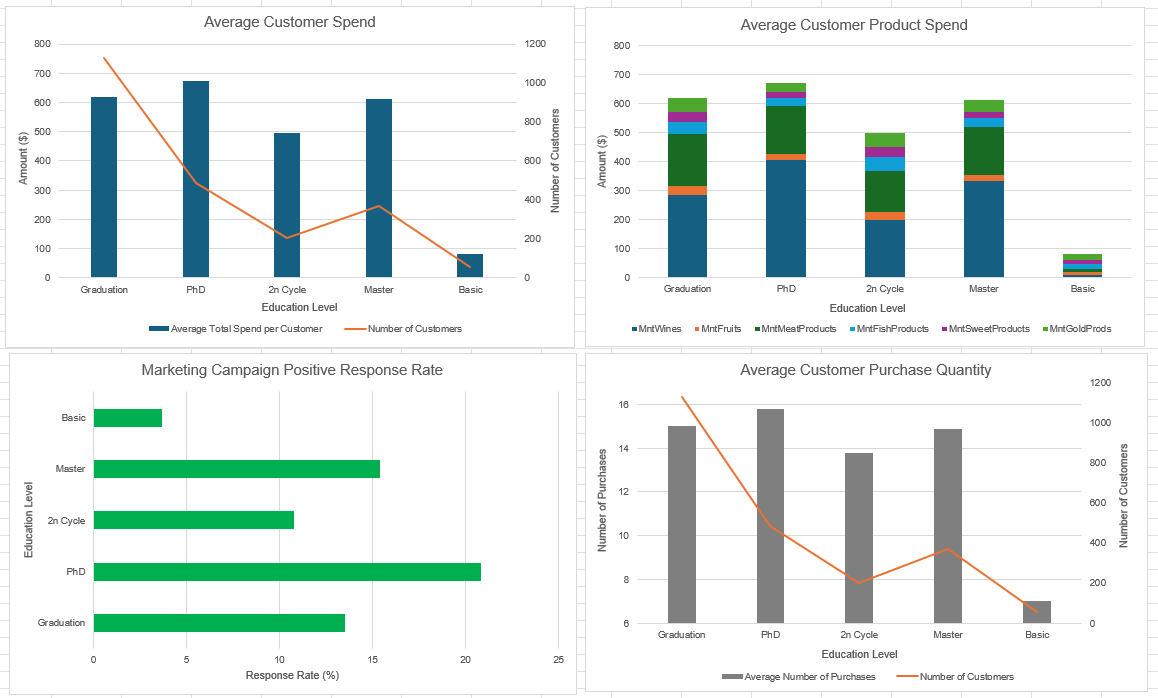

In [12]:
#The general format of a plotting function to use in a Streamlit app

def general_plot():
    fig, ax = plt.subplots()
    ax.bar()

    return fig

In [13]:
#Average Customer Spend (Bar) with Number of Customers (Line)

# Start with the education data:
education_metrics

{'Graduation': {'avg_total_mnt_spent': 619.9,
  'std_total_mnt_spent': 599.5,
  'range_total_mnt_spent': 2519,
  'avg_total_num_purchases': 15.0,
  'std_total_num_purchases': 7.6,
  'sum_purchases': 16894,
  'range_total_num_purchases': 43,
  'response_rate': 13.5,
  'no_customers': 1127},
 'PhD': {'avg_total_mnt_spent': 672.4,
  'std_total_mnt_spent': 616.1,
  'range_total_mnt_spent': 2432,
  'avg_total_num_purchases': 15.8,
  'std_total_num_purchases': 7.8,
  'sum_purchases': 7693,
  'range_total_num_purchases': 44,
  'response_rate': 20.8,
  'no_customers': 486},
 '2n Cycle': {'avg_total_mnt_spent': 496.5,
  'std_total_mnt_spent': 542.4,
  'range_total_mnt_spent': 2244,
  'avg_total_num_purchases': 13.8,
  'std_total_num_purchases': 8.0,
  'sum_purchases': 2802,
  'range_total_num_purchases': 38,
  'response_rate': 10.8,
  'no_customers': 203},
 'Master': {'avg_total_mnt_spent': 611.8,
  'std_total_mnt_spent': 623.4,
  'range_total_mnt_spent': 2515,
  'avg_total_num_purchases': 14.9

In [14]:
education_metrics['Graduation'].keys()

dict_keys(['avg_total_mnt_spent', 'std_total_mnt_spent', 'range_total_mnt_spent', 'avg_total_num_purchases', 'std_total_num_purchases', 'sum_purchases', 'range_total_num_purchases', 'response_rate', 'no_customers'])

In [15]:
#Need to get the average total monetary spent and number of customers for each education level

def extract_metric(metrics: dict, metric_name: str) -> dict:
    """
    Extracts a specific metric from the dictionary of metrics (generated from the 'calculate_metrics' function).

    Parameters:
    metrics (dict): A dictionary of metrics.
    metric_name (str): The name of the metric to extract. Can be one of the following:

    'avg_total_mnt_spent', 'std_total_mnt_spent', 'range_total_mnt_spent', 'avg_total_num_purchases', 'std_total_num_purchases', 'sum_purchases', 'range_total_num_purchases', 'response_rate', 'no_customers'

    Returns:
    dict: A dictionary containing the metric for each level.
    """
    
    return {level: metrics[level][metric_name] for level in metrics}

In [16]:
education_averages = extract_metric(education_metrics, 'avg_total_mnt_spent')
education_customers = extract_metric(education_metrics, 'no_customers')
education_averages, education_customers

({'Graduation': 619.9,
  'PhD': 672.4,
  '2n Cycle': 496.5,
  'Master': 611.8,
  'Basic': 81.8},
 {'Graduation': 1127, 'PhD': 486, '2n Cycle': 203, 'Master': 370, 'Basic': 54})

In [17]:
def plot_customer_spend_and_number(averages: dict, customers: dict):
    """
    Plots the average spend and number of customers for each level for the EMIB analysis.

    Parameters:
    averages (dict): A dictionary containing the average spend per customer for each level of a given feature.
    customers (dict): A dictionary containing the number of customers for each level of a given feature.

    Returns:
    matplotlib.figure.Figure: The plot figure.
    """
    fig, ax1 = plt.subplots()

    category_levels = list(averages.keys())
    avg_spend = list(averages.values())
    num_customers = list(customers.values())

    ax1.bar(category_levels, avg_spend, color='b', alpha=0.6, label='Average Spend')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Average Spend', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(category_levels, num_customers, color='r', marker='o', label='Number of Customers')
    ax2.set_ylabel('Number of Customers', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    fig.tight_layout()
    return fig


C:\Users\cochr\AppData\Local\Temp\ipykernel_9564\1565147339.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  education_averages_customers_plot.show()


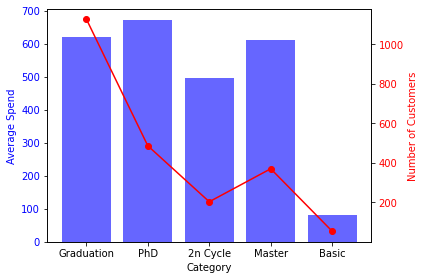

In [18]:
education_averages_customers_plot = plot_customer_spend_and_number(education_averages, education_customers)
education_averages_customers_plot.show()

In [19]:
education_response_rates = extract_metric(education_metrics, 'response_rate')
education_response_rates

{'Graduation': 13.5,
 'PhD': 20.8,
 '2n Cycle': 10.8,
 'Master': 15.4,
 'Basic': 3.7}

In [20]:
def plot_marketing_response(response_rates: dict) -> plt.Figure:
    """
    Plots the marketing response rates for each category level.

    Parameters:
    response_rates (dict): A dictionary where the keys are category levels (e.g., education levels) and the values are the response rates for each level.

    Returns:
    matplotlib.figure.Figure: The plot figure showing the response rates as a horizontal bar chart.
    
    """
    
    fig, ax1 = plt.subplots()

    category_levels = list(response_rates.keys())
    response_rate = list(response_rates.values())
    
    ax1.barh(category_levels, response_rate, color='g', alpha=0.6, label='Response Rate')
    ax1.set_xlabel('Response Rate', color='g')
    ax1.set_ylabel('Category')
    ax1.tick_params(axis='x', labelcolor='g')

    fig.tight_layout()
    return fig

C:\Users\cochr\AppData\Local\Temp\ipykernel_9564\2063844095.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  education_response_rate_plot.show()


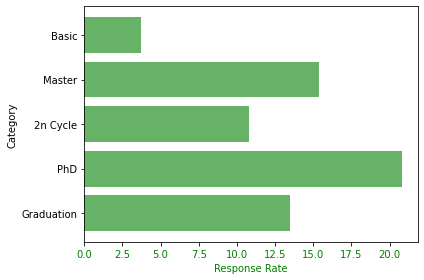

In [21]:
education_response_rate_plot = plot_marketing_response(education_response_rates)
education_response_rate_plot.show()

In [22]:
def plot_customer_average_purchase_quantity_and_number(purchase_quantity: dict, customers: dict):
    """
    Plots the average purchase quantity and number of customers for each category level.

    Parameters:
    purchase_quantity (dict): A dictionary where the keys are category levels (e.g., education levels) and the values are the average purchase quantities for each level.
    customers (dict): A dictionary where the keys are category levels and the values are the number of customers for each level.

    Returns:
    matplotlib.figure.Figure: The plot figure showing the average purchase quantities as a bar chart and the number of customers as a line chart.
    """
    
    fig, ax1 = plt.subplots()

    category_levels = list(purchase_quantity.keys())
    purchases = list(purchase_quantity.values())
    num_customers = list(customers.values())

    ax1.bar(category_levels, purchases, color='grey', alpha=0.6, label='Average Spend')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Average Purchase Quantity', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()
    ax2.plot(category_levels, num_customers, color='r', marker='o', label='Number of Customers')
    ax2.set_ylabel('Number of Customers', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    fig.tight_layout()
    return fig

C:\Users\cochr\AppData\Local\Temp\ipykernel_9564\3830804379.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_customer_average_purchase_quantity_and_number(education_average_purchase_quantity, education_customers).show()


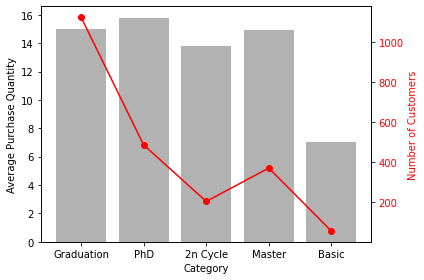

In [23]:
education_average_purchase_quantity = extract_metric(education_metrics, 'avg_total_num_purchases')
plot_customer_average_purchase_quantity_and_number(education_average_purchase_quantity, education_customers).show()

In [28]:
education_products = product_type_stats(data_by_education)
#Structure of this dictionary: {level: {product: {total_spent, average_spent, no_customers}}}

In [29]:
def extract_average_spent_per_product(category_products: dict) -> dict:
    """
    Extracts the average spent for each product type for each category level.

    Parameters:
    category_products (dict): A dictionary where the keys are the category levels and the values are dictionaries containing product spending statistics.

    Returns:
    dict: A dictionary where the keys are category levels and the values are dictionaries containing the average spent for each product type.
    """
    average_spent_per_product = {}
    
    for level, stats in category_products.items():
        average_spent_per_product[level] = stats['average_spent'].to_dict()
    
    return average_spent_per_product

# Example usage
average_spent_per_product = extract_average_spent_per_product(education_products)
print(average_spent_per_product)

{'Graduation': {'MntWines': 284.26885536823426, 'MntFruits': 30.774622892635314, 'MntMeatProducts': 179.48890860692103, 'MntFishProducts': 43.149955634427684, 'MntSweetProducts': 31.367346938775512, 'MntGoldProds': 50.849157054125996}, 'PhD': {'MntWines': 404.49588477366257, 'MntFruits': 20.049382716049383, 'MntMeatProducts': 168.60288065843622, 'MntFishProducts': 26.728395061728396, 'MntSweetProducts': 20.22222222222222, 'MntGoldProds': 32.31069958847737}, '2n Cycle': {'MntWines': 198.1822660098522, 'MntFruits': 28.95566502463054, 'MntMeatProducts': 141.25615763546799, 'MntFishProducts': 47.48275862068966, 'MntSweetProducts': 34.251231527093594, 'MntGoldProds': 46.399014778325125}, 'Master': {'MntWines': 333.07567567567565, 'MntFruits': 21.654054054054054, 'MntMeatProducts': 163.3783783783784, 'MntFishProducts': 32.1, 'MntSweetProducts': 21.175675675675677, 'MntGoldProds': 40.3972972972973}, 'Basic': {'MntWines': 7.2407407407407405, 'MntFruits': 11.11111111111111, 'MntMeatProducts': 1

C:\Users\cochr\AppData\Local\Temp\ipykernel_9564\2030778463.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_average_customer_spend_products(average_spent_per_product).show()


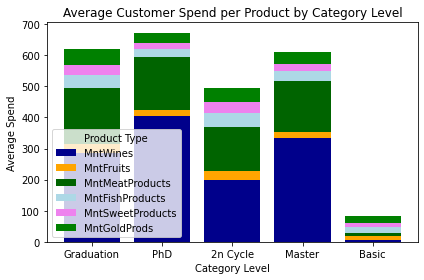

In [31]:
def plot_average_customer_spend_products(average_spent_per_product: dict):
    """
    Plots a stacked bar chart where the bars (for each level) are made up of a combination of the average spent for each product.

    Parameters:
    average_spent_per_product (dict): A dictionary where the keys are category levels and the values are dictionaries containing the average spent for each product type.

    Returns:
    matplotlib.figure.Figure: The plot figure showing the stacked bar chart.
    """
    fig, ax = plt.subplots()

    category_levels = list(average_spent_per_product.keys())
    product_types = list(next(iter(average_spent_per_product.values())).keys())

    # Initialize bottom to zero for stacking
    bottom = np.zeros(len(category_levels))

    colors = {
        'MntWines': 'darkblue',
        'MntFruits': 'orange',
        'MntMeatProducts': 'darkgreen',
        'MntFishProducts': 'lightblue',
        'MntSweetProducts': 'violet',
        'MntGoldProds': 'green'
    }

    for product in product_types:
        values = [average_spent_per_product[level][product] for level in category_levels]
        ax.bar(category_levels, values, bottom=bottom, label=product, color=colors[product])
        bottom += values

    ax.set_xlabel('Category Level')
    ax.set_ylabel('Average Spend')
    ax.set_title('Average Customer Spend per Product by Category Level')
    ax.legend(title='Product Type')

    fig.tight_layout()
    return fig

# Example usage
plot_average_customer_spend_products(average_spent_per_product).show()